In [1]:
#importing all the libraries needed
#!pip install sentence-transformers
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
import csv
import language_tool_python
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [2]:
# #file reading and writting
# # Set input file path
# input_file = 'student_papers.csv' #file uploaded by teacher

# # Read CSV file using pandas
# df = pd.read_csv(input_file)

# # Get answer column as a list
# answers = df['answers'].tolist()

# #storing the total number of answers
# num_ans = df['answers'].shape[0]

# #Reading the text file of student and converting it to csv file
# # Set input and output file paths
# a_input_file = 'a_input.txt'
# a_output_file = 'a_output.csv'

# # Open input and output files
# with open(a_input_file, 'r') as f_in, open(a_output_file, 'w', newline='') as f_out:
#     # Sort the lines by the first number
#     lines = sorted(f_in.readlines(), key=lambda x: int(x.split(')')[0]))

#     # Set up CSV writer with column names
#     writer = csv.writer(f_out)
#     writer.writerow(['number', 'a_answers','T_marks'])

#     # Initialize variable for expected number
#     expected_num = 1

#     # Loop through sorted lines in input file
#     for line in lines:
#         # Split line by number and answer text
#         parts = line.split(') ', maxsplit=1)

#         # If line starts with a number followed by a space and some text
#         if len(parts) == 2 and parts[0].isdigit():
            
#             num = int(parts[0])
#             # Check if number is within range
#             if num <= num_ans:
                
#                 # Write empty strings for any skipped numbers
#                 while expected_num < num:
#                     writer.writerow([str(expected_num), ''])
#                     expected_num += 1
        
#                 # Write number and answer text to CSV file
#                 writer.writerow([parts[0], parts[1].strip(), ''])
#                 expected_num += 1

#     # Write empty strings for any remaining numbers
#     while expected_num <= len(df):
#         writer.writerow([str(expected_num), ''])
#         expected_num += 1

# #reading the output file using pandas
# a_df = pd.read_csv('a_output.csv', keep_default_na=False)
# a_answers = a_df['a_answers'].tolist()

# #Copy the marks table from student_papers file a_output file
# a_df['T_marks'] = df['marks']
# # Write the updated a_output file
# a_df.to_csv('a_output.csv', index=False)

import sys

input_file = sys.argv[2]

# # Set input file path
# input_file = 'student_papers.csv' # This is the file uploaded by the teacher

# Read CSV file using pandas
df = pd.read_csv(input_file)

# Get answer column as a list
answers = df['answers'].tolist()

# Get the total number of answers in the file
num_ans = df['answers'].shape[0]

#Here input.txt is users file, we are coverting it to a_input.txt file to have a format that can be properly converted to our a_output.csv
# Open input file and output file
with open('sys.argv[1]', 'r') as input_file, open('a_input.txt', 'w') as output_file:
    previous_line_start = None
    # Loop through each line in the input file
    for line in input_file:
        # If the line is empty or only contains whitespace, skip the line
        if not line.strip():
            continue
        # If the line starts with a digit followed by a ')', it's the start of a new question
        if line[0].isdigit() and line[1] == ')':
            previous_line_start = line.strip()
            output_file.write('\n' + previous_line_start)
        # If the previous line was the start of a new question, and the current line is not the start of a new question
        elif previous_line_start is not None:
            # If the current line doesn't start with a digit, it's part of the answer
            if not line[0].isdigit() or (line[0].isdigit() and line[1] != ')'):
                output_file.write(line.strip())
                previous_line_start = None
            # If the current line starts with a digit followed by a ')', it's the start of a new question
            else:
                output_file.write('\n' + line.strip())
                previous_line_start = line.strip()
        # If the previous line was not the start of a new question, just write the line to the output file
        else:
            output_file.write(line)

# Open input and output files
# Set input and output file paths
a_input_file = 'a_input.txt'
a_output_file = 'a_output.csv'

# Open input and output files
with open(a_input_file, 'r') as f_in, open(a_output_file, 'w', newline='') as f_out:
    # Sort the lines by the first number
    lines = sorted(f_in.readlines(), key=lambda x: int(x.split(')')[0]) if x.strip() else float('inf'))

    # Set up CSV writer with column names
    writer = csv.writer(f_out)
    writer.writerow(['number','a_answers','questions','T_marks'])

    # Initialize variable for expected number
    expected_num = 1

    # Loop through sorted lines in input file
    for line in lines:
        # Split line by number and answer text
        parts = line.split(')', maxsplit=1)

        # If line starts with a number followed by a ')' and some text
        if len(parts) == 2 and parts[0].isdigit():
            num = int(parts[0])
            # Check if number is within range
            if num <= num_ans:
                # Write empty strings for any skipped numbers
                while expected_num < num:
                    writer.writerow([str(expected_num), ''])
                    expected_num += 1
                # Write number and answer text to CSV file
                writer.writerow([parts[0], parts[1].strip(), ''])
                expected_num += 1

    # Write empty strings for any remaining numbers
    while expected_num <= len(df):
        writer.writerow([str(expected_num), ''])
        expected_num += 1  

#reading the output file using pandas
a_df = pd.read_csv('a_output.csv', keep_default_na=False)

# Copy the question table from student_papers file a_output file
a_df['questions'] = df['questions']      

a_answers = a_df['a_answers'].tolist()

#Copy the marks table from student_papers file a_output file
a_df['T_marks'] = df['marks']

#This is to put the question column before answer in a_output file
a_df[['a_answers', 'questions']] = a_df[['questions', 'a_answers']]
a_df.rename(columns={'a_answers': 'question'}, inplace=True)
a_df.rename(columns={'questions': 'a_answers'}, inplace=True)

# Write the updated a_output file
a_df.to_csv('a_output.csv', index=False)


In [3]:
#training the model
model = SentenceTransformer('stsb-roberta-large')

# Create a list to store similarity scores
similarity_scores = []

for i in range(num_ans):
    sen1 = answers[i] #ans from students_paper
    sen2 = a_answers[i] #ans from output

    # Encode sentences
    emb1 = model.encode(sen1, convert_to_tensor=True)
    emb2 = model.encode(sen2, convert_to_tensor=True)

    # Calculate cosine similarity score
    cosine_scores = util.pytorch_cos_sim(emb1, emb2)

    # Store the similarity score in the list
    similarity_scores.append(cosine_scores.item())

    print(f"Similarity score of {i+1} answer:", cosine_scores.item())

# Add the similarity scores as a new column to the a_df DataFrame
a_df['similarity_scores'] = similarity_scores
# Save the updated DataFrame to a CSV file
a_df.to_csv('a_output.csv', index=False)

Similarity score of 1 answer: 0.6366521120071411
Similarity score of 2 answer: 0.509143590927124
Similarity score of 3 answer: 0.8209152817726135
Similarity score of 4 answer: 0.0651392862200737
Similarity score of 5 answer: 0.37221869826316833
Similarity score of 6 answer: 0.047318700700998306
Similarity score of 7 answer: 0.5033007860183716


In [5]:
#Iterating through each row and computing the marks scored based on the similarity found
for i in range(num_ans):
    similarity_score = a_df.loc[i, 'similarity_scores']
    marks = a_df.loc[i, 'T_marks']
    
    # Compute the marks-scored based on the similarity score and the marks
    if similarity_score >= 0.9:
        marks_scored = marks
    elif similarity_score >= 0.8:
        marks_scored = marks * 0.95
    elif similarity_score >= 0.75:
        marks_scored = marks * 0.85
    elif similarity_score >= 0.7:
        marks_scored = marks * 0.8  
    elif similarity_score >= 0.65:
        marks_scored = marks * 0.7
    elif similarity_score >= 0.6:
        marks_scored = marks * 0.5
    elif similarity_score >= 0.5:
        marks_scored = marks * 0.3   
    else:
        marks_scored = 0
    
    # Set the value of the marks-scored column in the same row
    a_df.loc[i, 'marks-scored'] = marks_scored

# Save the updated DataFrame to a CSV file
a_df.to_csv('a_output.csv', index=False)    

In [6]:
# Sum all row entries for each column
t_sums=df['marks'].sum()
sums = a_df['marks-scored'].sum()

# Print sums for each column
print(f"Total marks scored are {sums} out of {t_sums}")

Total marks scored are 15.950000000000001 out of 58


In [7]:
# #!pip install language_tool_python
# import language_tool_python

# tool = language_tool_python.LanguageTool('en-US')

# for i in range(num_ans):
#     text = a_answers[i]

#     matches = tool.check(text)
    
#     print(f"\nGrammatical errors in answer {i+1} are:")
#     error_count = len(matches)
#     if error_count == 0:
#         print("No grammatical errors found.")
#     else:
#         print(f"\nTotal grammatical errors found: {error_count}\n")
#     for match in matches:
#             print(f"- Error: {match.message}")
#             print(f"  Suggested correction: {match.replacements}\n")
# create a LanguageTool instance
tool = language_tool_python.LanguageTool('en-US')

# iterate over the answers and check for grammatical errors
for i in range(num_ans):
    text = a_answers[i]

    # check for errors using LanguageTool
    matches = tool.check(text)
    
    # print error report for the current answer
    print(f"\nGrammatical errors in answer {i+1}:")
    if not matches:
        print("No grammatical errors found.")
    else:
        print(f"\nTotal number of errors found: {len(matches)}")
        print(f"\nOriginal text: {text}")
        for j, match in enumerate(matches, 1):
            print(f"\nError {j}:")
            print(f"Description: {match.message}")
            print(f"Suggested correction: {', '.join(match.replacements)}")
            print(f"Context: {match.context}\n")




Grammatical errors in answer 1:

Total number of errors found: 2

Original text: The Giza Pyramids, built to endure an eternity, have done just that.The monumental tombs are relics of Egypt's Old Kingdom era and were constructed some 4,500 years ago.Egypt's pharaohs expected to become gods in the afterlife. To prepare for the next world they erected temples to the gods and massive pyramid tombs for themselves—filled with all the things each ruler would need to guide and sustain himself in the next world.

Error 1:
Description: Add a space between sentences.
Suggested correction:  The
Context: ...endure an eternity, have done just that.The monumental tombs are relics of Egypt's ...


Error 2:
Description: Add a space between sentences.
Suggested correction:  Egypt
Context: ...d were constructed some 4,500 years ago.Egypt's pharaohs expected to become gods in t...


Grammatical errors in answer 2:
No grammatical errors found.

Grammatical errors in answer 3:

Total number of errors foun

In [8]:
# # download stopwords
# nltk.download('stopwords')

# # download grammar tool
# tool = language_tool_python.LanguageTool('en-US')

# grammar_error_count = 0
# spelling_error_count = 0
# total_word_count = 0
# total_sentences=0

# # input text
# for i in range(num_ans):
#     text = a_answers[i]

#     # split text into sentences
#     sentences = sent_tokenize(text)

#     # set up stop words
#     stop_words = set(stopwords.words('english'))

#     # initialize variables
#     total_sentences += len(sentences)

#     for sentence in sentences:
#         # check grammar errors
#         matches = tool.check(sentence)
#         if len(matches) > 0:
#             grammar_error_count += 1

#         # check spelling errors
#         words = word_tokenize(sentence)
#         word_count = len(words)
#         total_word_count += word_count
#         for word in words:
#             if word.lower() not in stop_words and not word.isnumeric() and not word.isalpha():
#                 spelling_error_count += 1

# # calculate percentage errors
# grammar_error_percent = (grammar_error_count / total_sentences) * 100
# spelling_error_percent = (spelling_error_count / total_word_count) * 100

# print("Total Sentences:", total_sentences)
# print("Grammar Error Percentage:", grammar_error_percent)
# print("Spelling Error Percentage:", spelling_error_percent)

# download stopwords
nltk.download('stopwords')

# download grammar tool
tool = language_tool_python.LanguageTool('en-US')

grammar_error_count = 0
spelling_error_count = 0
total_word_count = 0
total_sentences=0

# input text
for i in range(num_ans):
    text = a_answers[i]

    # split text into sentences
    sentences = sent_tokenize(text)

    # set up stop words
    stop_words = set(stopwords.words('english'))

    # initialize variables
    total_sentences += len(sentences)

    for sentence in sentences:
        # check grammar errors
        matches = tool.check(sentence)
        if len(matches) > 0:
            grammar_error_count += 1

        # check spelling errors
        words = word_tokenize(sentence)
        word_count = len(words)
        total_word_count += word_count
        for word in words:
            if word.lower() not in stop_words and not word.isnumeric() and not word.isalpha():
                spelling_error_count += 1

# calculate percentage errors
if total_sentences == 0:
    grammar_error_percent = 0
else:
    grammar_error_percent = (grammar_error_count / total_sentences) * 100

if total_word_count == 0:
    spelling_error_percent = 0
else:
    spelling_error_percent = (spelling_error_count / total_word_count) * 100

print("Total Sentences:", total_sentences)
print("Grammar Error Percentage:", grammar_error_percent)
print("Spelling Error Percentage:", spelling_error_percent)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total Sentences: 9
Grammar Error Percentage: 22.22222222222222
Spelling Error Percentage: 14.743589743589745


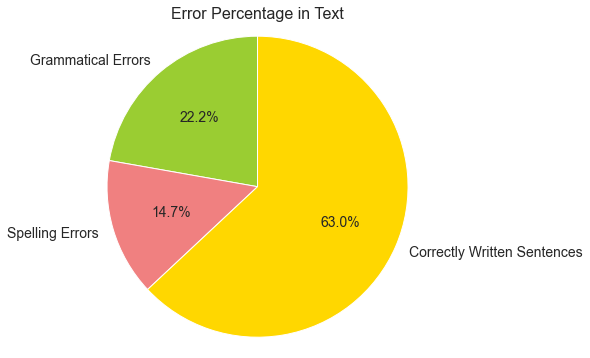

In [9]:
labels = ['Grammatical Errors', 'Spelling Errors', 'Correctly Written Sentences']
sizes = [grammar_error_percent, spelling_error_percent, 100-grammar_error_percent-spelling_error_percent]
colors = ['yellowgreen', 'lightcoral', 'gold']

sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})

plt.title("Error Percentage in Text", fontsize=16)
plt.axis('equal')
plt.show()


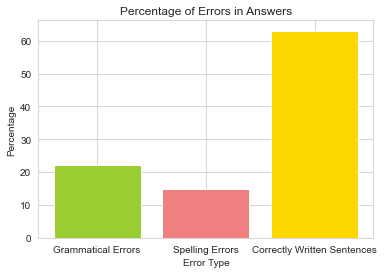

In [10]:
labels = ['Grammatical Errors', 'Spelling Errors', 'Correctly Written Sentences']
sizes = [grammar_error_percent, spelling_error_percent, 100-grammar_error_percent-spelling_error_percent]
colors = ['yellowgreen', 'lightcoral', 'gold']

plt.bar(labels, sizes, color=colors)
plt.title('Percentage of Errors in Answers')
plt.xlabel('Error Type')
plt.ylabel('Percentage')
plt.show()


In [11]:
a_df

number                        question  \
0       1        what is pyramid of Giza?   
1       2    What is great wall of China?   
2       3  Discuss painting of Mona lisa.   
3       4  Explain Industrial Revolution.   
4       5    Explain theory of Evaluation   
5       6             Explain Human Brain   
6       7    Explain Amerrican Civil war.   

                                           a_answers  T_marks  \
0  The Giza Pyramids, built to endure an eternity...        9   
1  The Great Wall of China is a series of fortifi...        8   
2  Mona Lisa, also called Portrait of Lisa Gherar...        7   
3                                                           9   
4  The brain is a complex organ that controls tho...        8   
5                                                           9   
6  American Civil War, also called War Between th...        8   

   similarity_scores  marks-scored  
0           0.636652          4.50  
1           0.509144          2.40  
2           0.820915          6.65  
3           0.065139          0.00  
4           0.372219          0.00  
5           0.047319          0.00  
6           0.503301          2.40